### <font color='blue'>Data Science na Indústria</font>
#### <font color='blue'>Previsão de falhasr potenciais ou necessidades de manutenção a partir de dados de sensores.</font>

**Objetivo:**
- Nesse projeto, para prever falhas potenciais ou necessidades de manutenção em máquinas, será aplicado a técnica de análise de Componentes Principais (PCA) ao dataset oritignal para reduzir sua dimensionaldidade, preservando as informações críticas, para facilitar a construção e eficiência do modelo preditivo, desempenho e ajudando a prevenir o sobreajuste (overfitting).

## Instalando e Carregando os Pacotes


In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Henrique Bardella" 
%watermark -v -m
%watermark --iversions

Author: Henrique Bardella

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

matplotlib: 3.7.1
pandas    : 1.5.0
sklearn   : 0.0
numpy     : 1.21.5



## Carregando e Compreendendo os Dados
- Primeiro, criaremos um conjunto de dados fictício com 8 características e 1000 observações usando o numpy, representando dados de sensores de máquinas industriais.

In [3]:
# Para reprodutibilidade
np.random.seed(42)

In [4]:
# Gera os dados
dados = np.random.randn(1000,8)
df_dsa = pd.DataFrame(dados, columns=[f'Atributo_{i}' for i in range(1, 9)])

In [5]:
df_dsa.shape

(1000, 8)

In [6]:
df_dsa.head()

,Atributo_1,Atributo_2,Atributo_3,Atributo_4,Atributo_5,Atributo_6,Atributo_7,Atributo_8
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435
1,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288
2,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748
3,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278
4,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861


## Padronização dos Dados

A padronização dos dados é uma técnica de pré-processamento em Machine Learning que transforma os valores de uma variável para que tenham média zero e desvio padrão de um. Isso é especialmente útil para algoritmos que dependem da distância entre as observações ou métodos baseados em gradiente, como redes neurais, pois ajuda a melhorar a convergência durante o treinamento. **O PCA requer os dados padronizados.**

Após a padronização, os dados resultantes têm uma média muito próxima de zero e um desvio padrão igual a um. Isso não apenas facilita a análise e o treinamento de modelos mas também ajuda a reduzir qualquer viés que possa ser introduzido por variáveis em escalas significativamente diferentes.

In [7]:
# Cria o padronizador
dsa_scaler = StandardScaler()

In [8]:
# Aplica o padronizados
dados_padronizados = dsa_scaler.fit_transform(df_dsa)

In [9]:
dados_padronizados

array([[ 0.50005258, -0.1079961 ,  0.69137884, ..., -0.2174599 ,
         1.54266063,  0.72124761],
       [-0.46570918,  0.57203085, -0.43181987, ..., -1.87318757,
        -1.65304186, -0.57797922],
       [-1.00882591,  0.34398554, -0.88126503, ..., -0.20921584,
         0.08058337, -1.42066048],
       ...,
       [-0.98387173,  0.75229737,  0.12308532, ..., -0.48368659,
        -0.05519563,  1.81736367],
       [ 0.24162393, -0.8096809 ,  0.25967332, ...,  0.5858837 ,
         1.18481977, -0.05231653],
       [ 1.6417944 ,  0.93706544, -0.67849748, ..., -0.81006669,
         1.61394232,  2.00153949]])

## Aplicando PCA às Variáveis de Entrada
-https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [12]:
# Cria o modelo
dsa_pca = PCA()

In [13]:
# Treina e aplica o modelo aos dados padronizados
dados_pca = dsa_pca.fit_transform(dados_padronizados)

In [14]:
dados_pca

array([[-1.00191225,  1.08652608,  0.70735925, ...,  0.04277897,
         0.46090549,  1.41207008],
       [ 1.56243282, -0.39897564, -1.94944629, ...,  0.79636812,
         0.20001234, -0.42570692],
       [ 1.86313495, -0.5654041 , -0.05326957, ..., -0.57754214,
         0.87677555, -0.399163  ],
       ...,
       [ 1.17332664,  0.20633089,  0.01206161, ..., -1.1537082 ,
        -0.72878039, -1.49490119],
       [-0.52775583, -0.30376184,  1.25823946, ..., -0.48839252,
         0.70099184,  0.11597958],
       [ 0.18891   ,  1.76142352,  1.47240733, ...,  1.55164509,
        -0.62971354,  2.29420302]])

## Calculando a Matriz de Covariância

No contexto do PCA, a matriz de covariância desempenha um papel vital. Para entender sua importância, vamos primeiro abordar o que ela é e como se relaciona com o PCA.

A matriz de covariância é uma matriz quadrada que mede a covariância entre cada par de variáveis em um conjunto de dados. Covariância, em termos simples, é uma medida de como duas variáveis variam juntas. Se ambas as variáveis tendem a aumentar ou diminuir juntas, a covariância é positiva; se uma variável tende a aumentar quando a outra diminui, a covariância é negativa; e se as variáveis não exibem qualquer tendência consistente de variação conjunta, a covariância é próxima de zero.

A principal motivação por trás do PCA é reduzir a dimensionalidade de um conjunto de dados mantendo o máximo de informação possível. O PCA busca identificar "direções" no espaço de dados que capturam a maior variância nos dados. Essas direções são os chamados componentes principais.

A relação entre a matriz de covariância e o PCA é que os componentes principais são determinados a partir dos autovetores da matriz de covariância. O primeiro componente principal é a direção (ou autovetor) que corresponde ao maior autovalor da matriz de covariância e, portanto, captura a maior variância nos dados. O segundo componente principal é a direção que captura a segunda maior variância, e assim por diante.

In [15]:
# Calcula a matriz de Covariância 
cov_matrix = np.cov(dados_padronizados, rowvar = False)
print(cov_matrix)

[[ 1.00100100e+00 -3.69357111e-02  3.06924109e-03 -3.40509104e-02
  -2.46119766e-02  1.71832531e-02  1.04925691e-02 -2.19223880e-02]
 [-3.69357111e-02  1.00100100e+00 -4.84707341e-02 -3.25134657e-02
  -6.87427050e-03 -5.40529525e-02  1.51251647e-02 -2.03757820e-02]
 [ 3.06924109e-03 -4.84707341e-02  1.00100100e+00 -2.26662376e-03
  -3.83098518e-02  2.49333208e-02 -3.98294504e-02 -8.44378492e-03]
 [-3.40509104e-02 -3.25134657e-02 -2.26662376e-03  1.00100100e+00
  -7.38873848e-02  2.97271555e-02 -8.86529733e-03  8.37242871e-04]
 [-2.46119766e-02 -6.87427050e-03 -3.83098518e-02 -7.38873848e-02
   1.00100100e+00 -1.17331628e-02 -2.74971107e-02  2.51417888e-02]
 [ 1.71832531e-02 -5.40529525e-02  2.49333208e-02  2.97271555e-02
  -1.17331628e-02  1.00100100e+00  3.13041748e-02 -1.05193266e-02]
 [ 1.04925691e-02  1.51251647e-02 -3.98294504e-02 -8.86529733e-03
  -2.74971107e-02  3.13041748e-02  1.00100100e+00  2.38964840e-02]
 [-2.19223880e-02 -2.03757820e-02 -8.44378492e-03  8.37242871e-04
   

## Visualizando a Variância Explicada

In [17]:
# Extrai a valiancia explicada
explained_variance = dsa_pca.explained_variance_ratio_

In [18]:
# Ajustar o range para começar de 1
componentes = range(1, len(explained_variance) + 1)

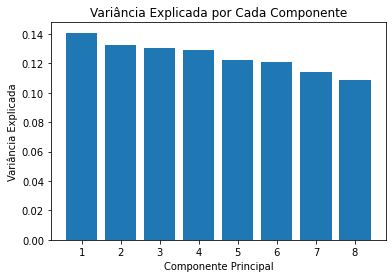

In [19]:
# Plot
plt.bar(componentes, explained_variance)

# Ajustar os ticks no eixo x
plt.xticks(componentes)

plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.title('Variância Explicada por Cada Componente')
plt.show()


## Identificação e Interpretação de Cada Componente

In [20]:
# Extraindo os componentes principais
componentes = pd.DataFrame(dsa_pca.components_, 
                           columns = df_dsa.columns, 
                           index = [f'PC-{i}' for i in range(1, 9)])

In [21]:
componentes

,Atributo_1,Atributo_2,Atributo_3,Atributo_4,Atributo_5,Atributo_6,Atributo_7,Atributo_8
PC-1,-0.196388,0.468139,-0.405046,-0.417747,0.436951,-0.448249,0.010965,0.108297
PC-2,-0.275254,0.406774,-0.350551,0.470875,-0.485621,-0.042320,0.420036,-0.010603
PC-3,0.389133,-0.176295,-0.305869,-0.250275,0.137979,0.371768,0.654928,0.274085
PC-4,0.542503,0.297805,0.009931,-0.296110,-0.291527,-0.101594,0.043470,-0.657285
PC-5,-0.263291,-0.017466,-0.357604,0.145364,0.401602,0.537062,-0.112864,-0.564716
PC-6,0.446916,-0.310198,-0.585621,0.388296,0.030855,-0.316280,-0.325487,0.058223
PC-7,-0.265614,-0.548444,0.058386,-0.008642,0.092213,-0.495751,0.462134,-0.396654
PC-8,0.316742,0.313520,0.380994,0.530533,0.546333,-0.120463,0.245726,-0.037217


A tabela acima mostra os coeficientes (ou cargas) de cada componente principal em relação a cada um dos atributos originais (Atributo_1, Atributo_2, etc.). Cada linha (PC-1, PC-2, etc.) representa um componente principal, e cada valor na linha indica a contribuição relativa de cada atributo original para esse componente principal. Aqui está como você pode interpretar esses valores:

**PC-1, PC-2, ..., PC-8**: Estes são os componentes principais obtidos da PCA. Cada componente é uma combinação linear dos atributos originais.

**Valores na tabela (por exemplo, para PC-1: -0.196388 para Atributo_1, 0.468139 para Atributo_2, etc.)**: Esses números mostram como cada atributo original contribui para o componente principal correspondente. Um valor alto (positivo ou negativo) indica uma contribuição significativa desse atributo ao componente principal, enquanto um valor próximo de zero indica pouca ou nenhuma contribuição.

Como interpretar cada componente:

**PC-1**: Tem altas cargas (em magnitude) para os Atributos 2, 3, 4, 5 e 6, indicando que esses atributos são importantes para este componente. Os sinais opostos (positivo e negativo) podem indicar correlações inversas entre estes atributos no contexto deste componente.

**PC-2**: Mostra cargas significativas e contrárias para os Atributos 4 e 5, e também tem contribuições consideráveis de Atributos 2 e 3.

**PC-3**: É dominado pelos Atributos 6 e 7, com contribuições positivas substanciais, indicando que esses atributos variam juntos de forma significativa nesta dimensão.

**PC-4 a PC-8**: Cada um destes tem um padrão distinto de contribuições dos atributos, indicando diferentes inter-relações entre os atributos quando vistos através desses componentes.

## Escolhendo o Número Ideal de Componentes com Validação Cruzada

Usaremos um modelo de regressão logística e verificaremos o desempenho do modelo com diferentes números de componentes.

Vamos adcionar uma nova coluna com dois valores possíveis:

- 0 indicando que a máquina não precisou de manutenção preditiva (classe negativa).
- 1 indicando que a máquina precisou de manutenção preditiva (classe positiva).

In [23]:
# Adicionando a variável target
df_dsa['target'] = np.random.randint(0, 2, df_dsa.shape[0])

In [24]:
df_dsa.head()

,Atributo_1,Atributo_2,Atributo_3,Atributo_4,Atributo_5,Atributo_6,Atributo_7,Atributo_8,target
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,1
1,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,0
2,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,1
3,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,1
4,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0


In [25]:
scores = []

In [26]:
# Loop sobre o número de componentes do PCA de 1 a 8
for i in range(1, 9):
    
    # Cria um objeto PCA com i componentes
    pca = PCA(n_components = i)
    
    # Ajusta o PCA aos dados escalonados e transforma os dados
    pca_data = pca.fit_transform(dados_padronizados)
    
    # Cria um objeto de regressão logística
    lr = LogisticRegression()
    
    # Avalia a regressão logística usando validação cruzada e calcula a média das pontuações
    score = cross_val_score(lr, pca_data, df_dsa['target'], cv = 5).mean()
    
    # Adiciona a média das pontuações à lista de pontuações
    scores.append(score)

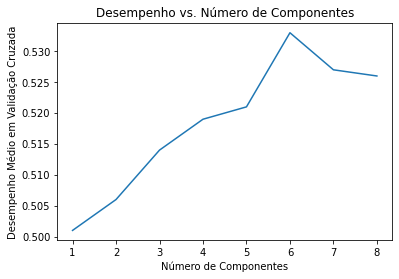

In [27]:
# Plot
plt.plot(range(1, 9), scores)
plt.xlabel('Número de Componentes')
plt.ylabel('Desempenho Médio em Validação Cruzada')
plt.title('Desempenho vs. Número de Componentes')
plt.show()

## Criando o Modelo Final com os Componentes Principais

Aqui, escolhemos o número ideal de componentes com base no gráfico anterior e treinamos nosso modelo com esse número.

In [28]:
# Considerando que 6 é o número ideal de componentes
pca_final = PCA(n_components = 6)
pca_data_final = pca_final.fit_transform(dados_padronizados)
modelo_dsa_lr_final = LogisticRegression()
modelo_dsa_lr_final.fit(pca_data_final, df_dsa['target'])

LogisticRegression()

In [29]:
# Simulando novos dados de sensores de uma máquina industrial
novos_dados_sensores = np.random.randn(1, 8)

In [30]:
novos_dados_sensores

array([[ 0.63122436, -1.15122666,  1.1049972 , -0.37753115,  1.25761311,
        -0.53345245, -1.02662548, -0.45813699]])

In [31]:
# Padroniza os dados de entrada
novos_dados_padronizados = dsa_scaler.transform(novos_dados_sensores)

In [32]:
# Aplica o PCA
pca_new_data = pca_final.transform(novos_dados_padronizados)

In [33]:
# Previsão com novos dados
previsao = modelo_dsa_lr_final.predict(pca_new_data)
print(previsao)

[1]


> De acordo com os dados de entrada essa máquina precisa de manutenção preventiva.